Nous allons travailler sur un corpus audio contenant 10 classes (craquement de feu, horloge, chant de coq, etc...).

Les fichiers audio sont convertis en spectrogrammes, une représentation temps/fréquence du signal qui peut être vue comme une image.


### Imports



In [1]:
import os
import random
import requests
import zipfile
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


import numpy as np
import matplotlib.pyplot as plt

Installation de la bibliothèque **librosa** qui lit les fichiers audio et extrait les spectrogrammes qui seront traités ensuite comme des images.

In [2]:
!pip -q install librosa
import librosa
import librosa.display

### Chargement du corpus

Le corpus est constitué de 10 concepts audio qui sont :
* **tronçonneuse** *(chainsaw)*
* **tic-tac d'une horloge** *(clock_tick)*
* **craquement de feu** *(crackling_fire)*
* **pleurs de bébé** *(crying_baby)*
* **chien** *(dog)*
* **hélicoptère** *(helicopter)*
* **pluie** *(rain)*
* **coq** *(rooster)*
* **bruit des vagues** *(sea_waves)*
* **éternuement** *(sneezing)*

Nous voulons classer les différents fichiers audio suivant ces 10 classes.

#### Téléchargement du corpus


In [3]:
!wget -O dataset.zip https://www.irit.fr/~Thomas.Pellegrini/ens/M2RFA/dataset.zip
!unzip -qq dataset.zip -d data/
!rm dataset.zip

--2022-08-14 12:51:37--  https://www.irit.fr/~Thomas.Pellegrini/ens/M2RFA/dataset.zip
Resolving www.irit.fr (www.irit.fr)... 141.115.28.2
Connecting to www.irit.fr (www.irit.fr)|141.115.28.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128685900 (123M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>] 122.72M  2.27MB/s    in 55s     

2022-08-14 12:52:34 (2.22 MB/s) - ‘dataset.zip’ saved [128685900/128685900]



La base de données téléchargée est stockée dans :

```
./data
```


In [4]:
base_dir = './data'

#### Chargement du corpus dans la mémoire

La fonction **load_dataset** permet de charger les données d'apprentissage ou les données de test en mémoire.

**Attention :** le chargement est un peu long (environ 2min)

In [5]:
idx_to_classes = ['chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby',
                  'dog', 'helicopter', 'rain', 'rooster', 'sea_waves',
                  'sneezing']


def load_dataset(path):
    spec = []
    labels = []
    for idx, label in enumerate(idx_to_classes):
        with os.scandir(os.path.join(path, label)) as it:
            for entry in it:
                if (not entry.name.startswith('.')
                        and entry.name.endswith('.wav')):
                    # load audio
                    y, sr = librosa.load(entry.path)
                    # convert audio to melspectrogram
                    spec.append(librosa.core.power_to_db(librosa.feature.melspectrogram(y, sr,
                                                              n_fft=2048,
                                                              hop_length=512,
                                                              power=2.0)))
                    
                    # add associated label
                    labels.append(idx)

    # mélange les données 
    #combined = list(zip(spec, labels))
    #random.shuffle(combined)
    #spec, labels = zip(*combined)
    return np.array(spec), np.array(labels)

In [6]:
# Le chargement des données est assez long : environ 2 min
%%time

print("Chargement du corpus d'apprentissage")
train_dir = os.path.join(base_dir, 'train')
x_train, y_train = load_dataset(train_dir)

print("Chargement du corpus de test")
test_dir = os.path.join(base_dir, 'test')
x_test, y_test = load_dataset(test_dir)

Chargement du corpus d'apprentissage
Chargement du corpus de test
CPU times: user 1min 40s, sys: 40.7 s, total: 2min 20s
Wall time: 1min 33s


#### Taille du corpus

Affichage de la taille du corpus. Pour cela, il suffit de compter le nombre d'images qu'il y a dans les dossiers correspondant à chaque label aussi bien dans le corpus d'apprentissage que dans le corpus de test.

In [7]:
# Affichage du nombre d'exemples totales dans le corpus
print('Taille du corpus total')
print('\t• train :', len(x_train), 'exemples')
print('\t• test :', len(x_test), 'exemples')

# Affichage de la taille des images et des labels dans le corpus 
print('\nTaille des données d\'apprentissage')
print('\t• X_train (images) :', x_train.shape)
print('\t• y_train (labels) :', y_train.shape)

print('\nTaille des données de test')
print('\t• X_test (images) :', x_test.shape)
print('\t• y_test (labels) :', y_test.shape)

Taille du corpus total
	• train : 320 exemples
	• test : 80 exemples

Taille des données d'apprentissage
	• X_train (images) : (320, 128, 216)
	• y_train (labels) : (320,)

Taille des données de test
	• X_test (images) : (80, 128, 216)
	• y_test (labels) : (80,)


**Correspondance ID du label / signification**

Définition de la liste *idx_to_classes* permettant à partir de la valeur du label de retrouver sa signification

In [8]:
idx_to_classes = ['chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby',
                  'dog', 'helicopter', 'rain', 'rooster', 'sea_waves',
                  'sneezing']

# du corpus d'apprentissage
print("Affichage de la correspondance des labels :")
for i in range(10):
    n = random.randint(0, len(y_train)-1)
    print('• y_train[' + str(n) + '] =', y_train[n], '->', idx_to_classes[y_train[n]])

Affichage de la correspondance des labels :
• y_train[171] = 5 -> helicopter
• y_train[63] = 1 -> clock_tick
• y_train[260] = 8 -> sea_waves
• y_train[203] = 6 -> rain
• y_train[252] = 7 -> rooster
• y_train[106] = 3 -> crying_baby
• y_train[266] = 8 -> sea_waves
• y_train[184] = 5 -> helicopter
• y_train[27] = 0 -> chainsaw
• y_train[150] = 4 -> dog


**Affichage de quelques spectrogrammes**


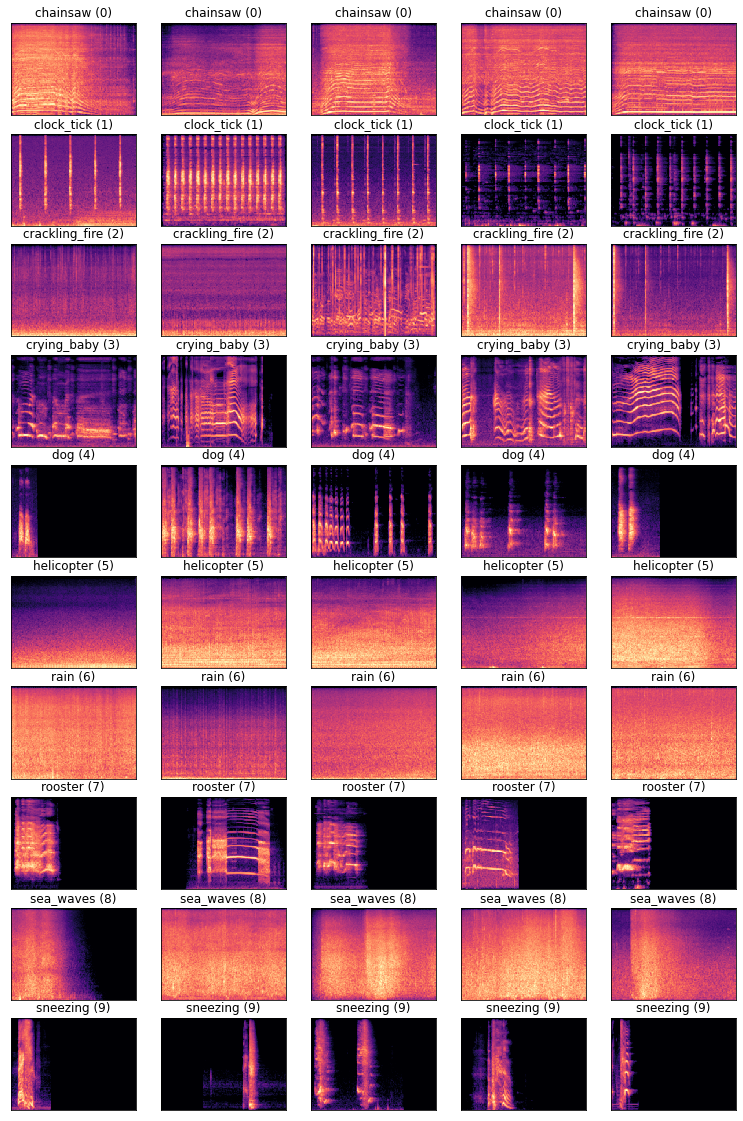

In [9]:
plt.figure(figsize=(13,20))

n = 0
for i in range(10):
    for j in range(5):
        # récupération d'une image et de son label associé
        img, target = x_train[n+j], y_train[n+j]
        # affiche du spectrogramme
        plt.subplot(10,5,i*5+j+1)
        # img = librosa.power_to_db(img)
        librosa.display.specshow(img, cmap='magma')
        # ajout d'un titre à l'image
        plt.title('{} ({})'.format(idx_to_classes[target], target))
        #plt.colorbar(format='%+2.0f dB')
    n += 32
              
plt.show()

# Générateurs de données pour Pytorch

Création d'un générateur de données (un « DataLoader ») pour les jeux de train et de test

In [10]:
nb_classes = 10

# numpy vers tensors
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)


height = x_train[0].shape[0]
width = x_train[0].shape[1]
print(height, width)

# numpy vers tensors
X_train = torch.from_numpy(x_train)
X_test = torch.from_numpy(x_test)


128 216


In [11]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, x_data, y_labels):
        'Initialization'
        self.y = y_labels
        self.x = x_data

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.x)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        X = self.x[index].unsqueeze_(0)
        y = self.y[index]

        return X, y

dataset_train = Dataset(X_train, y_train)
dataset_test = Dataset(X_test, y_test)

In [12]:
batch_size=32

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=1)

## Classification de fichiers audio en utilisant de l'apprentissage profond

Maintenant nous allons implémenter différentes architectures de réseaux de neurones.

Pour cela, on doit :
* faire l'architecture MLP puis celle du CNN plus bas;
* lancer l'apprentissage ;
* évaluer les modèles sur le jeu de test ;


### Réseau MLP

Definition des couches avec comme fonction d'activation RELU.

In [13]:
# Perceptron multi-couche 
class MLP(nn.Module):
    def __init__(self, num_hidden=50):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(128*216, num_hidden)
        self.layer2 = nn.Linear(num_hidden,50)
        # on peut définir d'autres couches dans un deuxième temps
        self.layer3 = nn.Linear(50,10)

    def forward(self, spectro):
        flattened = spectro.view(-1, 128*216) # flatten le spectro
        activation1 = self.layer1(flattened)
        activation1 = torch.relu(activation1)
        activation2 = self.layer2(activation1)
        activation2 = torch.relu(activation2)
        activation3 = self.layer3(activation2)
        #activation3 = F.softmax(activation3)
        return activation3


Fonction d'apprentissage

In [14]:
def train(model, batch_size=32, weight_decay=0.0,
          optimizer="sgd", learning_rate=0.1, momentum=0.9, 
          num_epochs=10):
    
    # la loss 
    criterion = nn.CrossEntropyLoss()
    # l'optimiseur
    assert optimizer in ("sgd", "adam")
    if optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(),
                              lr=learning_rate,
                              momentum=momentum,
                              weight_decay=weight_decay)
    else:
        optimizer = optim.Adam(model.parameters(),
                               lr=learning_rate,
                               weight_decay=weight_decay)
    # on track la learning curve avec des listes
    iters, iters_acc, losses, train_acc, val_acc = [], [], [], [], []
    # training
    n = 0 # nombre d'iterations (pour faire des figures)
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            #if imgs.size()[0] < batch_size:
            #   continue
            #print(imgs.size())

            model.train() # met le modèle en mode train
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # sauvegarde iteration et loss
            iters.append(n)
            losses.append(float(loss)/batch_size)             # loss moyen

            if n % 20 == 0 :
              train_acc.append(get_accuracy(model, train=True)) # training accuracy 
              val_acc.append(get_accuracy(model, train=False))  # test accuracy
              iters_acc.append(n)

            n += 1

    # plotting
    plt.title("Courbe d'apprentissage")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Courbe d'apprentissage")
    plt.plot(iters_acc, train_acc, label="Train")
    plt.plot(iters_acc, val_acc, label="Test")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Précision finale Train : {}".format(train_acc[-1]))
    print("Précision finale Test : {}".format(val_acc[-1]))

In [15]:
def get_accuracy(model, train=False):
    if train:
        data = train_loader
    else:
        data = test_loader

    model.eval() # met le modèle en mode test (inhibe le dropout par exemple)
    correct = 0
    total = 0
    for inp, labels in data:
        output = model(inp) # pas besoin de torch.softmax
        pred = output.max(1, keepdim=True)[1] # retrouve l'indice de la log-proba maximale
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += inp.shape[0]
    return (correct / total,correct)

Instanciation d'un MLP avec 50 neurones pour la couche cachée. Quel est le nombre de paramètres de ce modèle ?

In [16]:
model = MLP(50)
print(model)

MLP(
  (layer1): Linear(in_features=27648, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=10, bias=True)
)


In [18]:
def print_num_parameters(model):
    print("Nombre de paramètres :",
          sum(p.numel() for p in model.parameters()))
    
print_num_parameters(model)

Nombre de paramètres : 1385510


Nombre de paramètres du modéle MLP : 1382960

On teste un apprentissage de 10 epochs, avec l'optimiseur ADAM, un taux d'apprentissage à 0.0001, une taille de batch de 32 exemples.

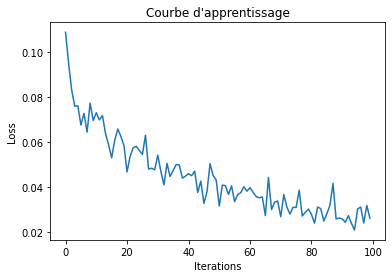

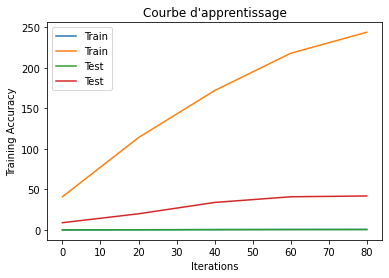

Précision finale Train : (0.7625, 244)
Précision finale Test : (0.525, 42)


In [19]:
train(model,optimizer="adam", learning_rate=0.00001)

On voit que le MLP n'est pas très performant. Vu le résultat sur les données de test


Passons à un réseau convolutif, un CNN. 

Son implémentation est ci-dessous, pour définir trois couches de convolution avec des noyaux de taille 3x3 et à 8, 16 et 32 canaux en sortie respectivement. 

On a complété les dimensions qui vont bien pour les deux couches fully-connected fc1 et fc2. fc1 a 50 neurones et fc2 10 neurones pour les 10 classes. 

Une ReLU sera appliquée après chaque couche de convolution et après fc1. 

Le pooling s'applique après chaque couche de convolution.

On peut afficher les dimensions de la sortie de la dernière couche de convolution, après le pooling, pour déterminer la dimension que nous devons règler pour la couche fc1.


In [20]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8,kernel_size=(3,3))
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3))
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3))

        

        # dim de la derniere couche de conv (32,32,14,25) 
        self.fc1 = nn.Linear(32*14*25, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        #print(x.size())
        x = x.view(-1,32*14*25 ) #flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x)
        return x

Instanciation du modèle CNN et affichage de son nombre de paramètres

In [21]:
model_cnn = CNN()

In [22]:
print_num_parameters(model_cnn)

Nombre de paramètres : 566448


Test d'un apprentissage de 10 epochs, avec l'optimiseur ADAM, un taux d'apprentissage à 0.0001, une taille de batch de 32 exemples.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


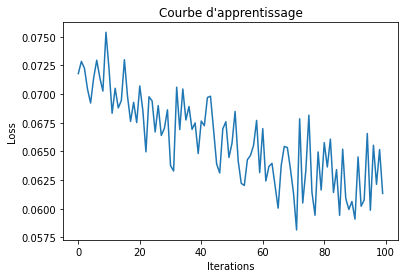

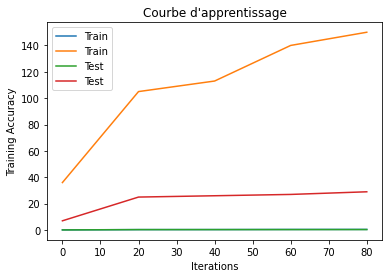

Précision finale Train : (0.46875, 150)
Précision finale Test : (0.3625, 29)


In [23]:
train(model_cnn, optimizer="adam", learning_rate=0.0001)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


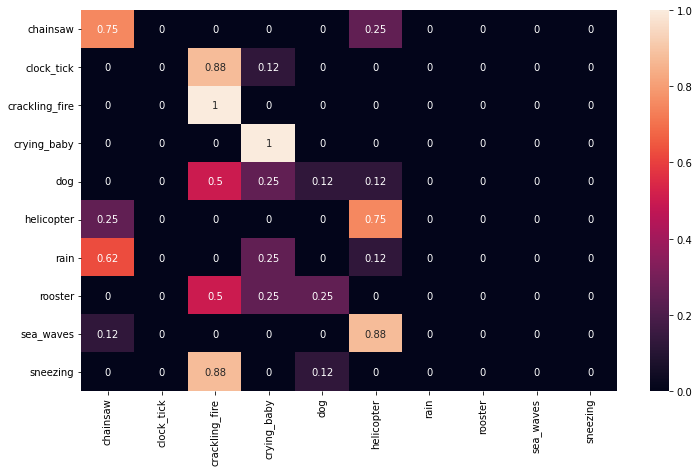

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        output = model_cnn(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth



# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in idx_to_classes],
                     columns = [i for i in idx_to_classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

Pour chaque modèle, nous avons ajusté les hyperparamètres, changé le nombre de couches ou encore testé plusieurs fonctions d’activations afin qu’ils puissent atteindre leur meilleur niveau de performance.
Sur la base de nos expérimentations , nous avons pu démontrer que le CNN est plus performant que le MLP lors de la classification des images.
Le CNN est préférable car il a moins de paramètres et essaie de réduire les dimensions de l'image alors qu'en cas de MLP, le nombre de paramètres dépend des données. Le CNN utilise des couches spéciales de convolution et de mise en commun alors que le MLP n'est qu'un réseau de neurones.
La précision dans les deux cas est bonne, mais pour de meilleurs résultats, nous préférons toujours le modèle CNN.
Cependant les CNN ne restent pas sans limite, car elles ne sont pas trop adaptées aux données à taille non fixe, comme par exemple les séquences de mots.